## 多类别逻辑回归、前馈神经网络

其实神经网络就像是logistic regression，只不过我们把logistic regression中的输入向量$\left[ x_1\sim {x_3} \right]$ 变成了中间层的$\left[ a_1^{(2)}\sim a_3^{(2)} \right]$, 即: $h_\theta(x)=g\left( \Theta_0^{\left( 2 \right)}a_0^{\left( 2 \right)}+\Theta_1^{\left( 2 \right)}a_1^{\left( 2 \right)}+\Theta_{2}^{\left( 2 \right)}a_{2}^{\left( 2 \right)}+\Theta_{3}^{\left( 2 \right)}a_{3}^{\left( 2 \right)} \right)$ 我们可以把$a_0, a_1, a_2, a_3$看成更为高级的特征值，也就是$x_0, x_1, x_2, x_3$的进化体，并且它们是由 $x$与$\theta$决定的，因为是梯度下降的，所以$a$是变化的，并且变得越来越厉害，所以这些更高级的特征值远比仅仅将 $x$次方厉害，也能更好的预测新数据。 这就是神经网络相比于逻辑回归和线性回归的优势。

In [1]:
# 这是一个MATLAB格式的.m文件，其中包含5000个20*20像素的手写字体图像，以及他对应的数字。另外，数字0的y值，对应的是10 用Python读取我们需要使用SciPy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat
from sklearn.metrics import classification_report#这个包是评价报告

In [2]:
data = loadmat('../data/andrew_ml_ex33507/ex3data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

## 数据可视化

In [9]:
# 随机展示20个数据
sample_idx = np.random.choice(np.arange(data['X'].shape[0]), 25)
sample_images = data['X'][sample_idx, :]
sample_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

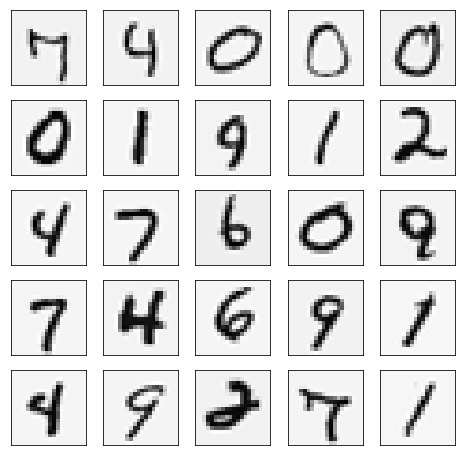

In [11]:
#展示二进制图
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(8, 8))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(sample_images[5 * r + c].reshape((20, 20))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

## 逻辑回归向量化
现在有10个数字类别，所以你需要训练10个不同的逻辑回归分类器。为了让训练效率更高，将逻辑回归向量化是非常重要

利用前面的逻辑回归方式


In [12]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [13]:
# 实现正则化的代价函数,矩阵方式
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / (2 * len(X))) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / len(X) + reg

In [41]:
# 正则梯度下降(理解，循环θ)
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    error = sigmoid(X * theta.T) - y
    grad = (np.dot(error.T, X)/len(X)) - (learningRate * theta)/len(X)
    grad[0] = grad[0] + (learningRate * theta[0])/len(X)#np.sum(np.multiply(error, X[:,0])) / len(X)
    return grad

## 一对多分类器

已经定义了代价函数和梯度函数，现在是构建分类器的时候了。 对于这个任务，我们有10个可能的类，并且由于逻辑回归只能一次在2个类之间进行分类，我们需要多类分类的策略。 在本练习中，我们的任务是实现一对一全分类方法，其中具有k个不同类的标签就有k个分类器，每个分类器在“类别 i”和“不是 i”之间决定。 我们将把分类器训练包含在一个函数中，该函数计算10个分类器中的每个分类器的最终权重，并将权重返回为k*(n + 1)数组，其中n是参数数量

In [32]:
from scipy.optimize import minimize
#当我我们需要预测多个结果（y=1 y=2..y=10）循环找到1，2...到10的训练集，分别训练，分别得到我们需要的特征值
def one_vs_all(X, y, num_labels, learning_rate):
    rows = X.shape[0]
    params = X.shape[1]
    # 当我我们需要预测多个结果（y=1 y=2..y=10）
    all_theta = np.zeros((num_labels, params + 1))
    # insert a column of ones at the beginning for the intercept term
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    # 循环找到1，2...到10的训练集，分别训练，分别得到我们需要的特征值
    for i in range(1, num_labels + 1):
        theta = np.zeros(params + 1)
        # 分别求对应结果的训练集
        y_i = np.array([1 if value == i else 0 for value in y])
        y_i = np.reshape(y_i, (rows, 1))
        # minimize the objective function
        fmin = minimize(fun=costReg, x0=theta, args=(X, y_i, learning_rate), method='TNC', jac=gradientReg)
        all_theta[i-1,:] = fmin.x
    return all_theta

这里需要注意的几点：首先，我们为theta添加了一个额外的参数（与训练数据一列），以计算截距项（常数项）。 其次，我们将y从类标签转换为每个分类器的二进制值（要么是类i，要么不是类i）。 最后，我们使用SciPy的较新优化API来最小化每个分类器的代价函数。 如果指定的话，API将采用目标函数，初始参数集，优化方法和jacobian（渐变）函数。 然后将优化程序找到的参数分配给参数数组。

实现向量化代码的一个更具挑战性的部分是正确地写入所有的矩阵，保证维度正确。

In [37]:
rows = data['X'].shape[0]
params = data['X'].shape[1]
#初始化theta10 * 401
all_theta = np.zeros((10, params + 1))
# 第一列x0 为1
X = np.insert(data['X'], 0, values=np.ones(rows), axis=1)
#
theta = np.zeros(params + 1)
y_0 = np.array([1 if label == 0 else 0 for label in data['y']])
y_0 = np.reshape(y_0, (rows, 1))
X.shape, y_0.shape, theta.shape, all_theta.shape

((5000, 401), (5000, 1), (401,), (10, 401))

In [35]:
np.unique(data['y'])#看下有几类标签

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [42]:
# 让我们确保我们的训练函数正确运行，并且得到合理的输出。
all_theta = one_vs_all(data['X'], data['y'], 10, 1)
all_theta

array([[-1.42277040e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.49109799e-03,  2.89460382e-07,  0.00000000e+00],
       [-3.56398244e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.69046082e-03, -5.41331905e-04,  0.00000000e+00],
       [-4.99081907e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.37580329e-05,  3.22944235e-07,  0.00000000e+00],
       ...,
       [-8.82347142e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.05980145e-04,  8.49198466e-06,  0.00000000e+00],
       [-4.92406072e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -5.28568312e-04,  3.46431197e-05,  0.00000000e+00],
       [-4.06678691e+00,  0.00000000e+00,  0.00000000e+00, ...,
         5.12680692e-04,  1.47857381e-05,  0.00000000e+00]])

##  一对多预测
我们现在准备好最后一步 - 使用训练完毕的分类器预测每个图像的标签。 对于这一步，我们将计算每个类的类概率，对于每个训练样本（使用当然的向量化代码），并将输出类标签为具有最高概率的类。

In [43]:
def predict_all(X, all_theta):
    rows = X.shape[0]
    params = X.shape[1]
    num_labels = all_theta.shape[0]
    X = np.insert(X, 0, values=np.ones(rows), axis=1)
    # z转换成矩阵
    X = np.matrix(X)
    all_theta = np.matrix(all_theta)#（10，401）
    # 计算sigmoid值 shape=（5000，10）
    h = sigmoid(X * all_theta.T)
    # 找到每行计算的最大值，就是当前一行的训练集计算预测最大的y值
    h_argmax = np.argmax(h, axis=1)
    # 由于我们插入了新值θ0，后续计算这里要去掉第一行
    h_argmax = h_argmax + 1
    return h_argmax

In [47]:
# 现在我们可以使用predict_all函数为每个实例生成类预测，看看我们的分类器是如何工作的。
y_pred = predict_all(data['X'], all_theta)
# 打印预测分析
# sklearn中的classification_report函数用于显示主要分类指标的文本报告．在报告中显示每个类的精确度，召回率，F1值等信息。
print(classification_report(data['y'], y_pred))
# support列为每个标签的出现次数 precision recall f1-score三列分别为各个类别的精确度/召回率及 F1值．

precision    recall  f1-score   support

           1       0.95      0.98      0.97       500
           2       0.94      0.92      0.93       500
           3       0.94      0.91      0.93       500
           4       0.93      0.95      0.94       500
           5       0.93      0.92      0.92       500
           6       0.97      0.98      0.98       500
           7       0.95      0.95      0.95       500
           8       0.92      0.92      0.92       500
           9       0.91      0.91      0.91       500
          10       0.98      0.99      0.99       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



##  神经网络
前面一个部分，我们已经实现了多分类逻辑回归来识别手写数字。但是，逻辑回归并不能承载更复杂的假设，因为他就是个线性分类器。 这部分，你需要实现一个可以识别手写数字的神经网络。神经网络可以表示一些非线性复杂的模型。权重已经预先训练好，你的目标是在现有权重基础上，实现前馈神经网络。

$a_{1}^{(2)}=g(\Theta {10}^{(1)}{{x}{0}}+\Theta {11}^{(1)}{{x}{1}}+\Theta {12}^{(1)}{{x}{2}}+\Theta {13}^{(1)}{{x}{3}})$ $a_{2}^{(2)}=g(\Theta {20}^{(1)}{{x}{0}}+\Theta {21}^{(1)}{{x}{1}}+\Theta {22}^{(1)}{{x}{2}}+\Theta {23}^{(1)}{{x}{3}})$ $a_{3}^{(2)}=g(\Theta {30}^{(1)}{{x}{0}}+\Theta {31}^{(1)}{{x}{1}}+\Theta {32}^{(1)}{{x}{2}}+\Theta {33}^{(1)}{{x}{3}})$ ${{h}_{\Theta }}(x)=g(\Theta {10}^{(2)}a{0}^{(2)}+\Theta {11}^{(2)}a{1}^{(2)}+\Theta {12}^{(2)}a{2}^{(2)}+\Theta {13}^{(2)}a{3}^{(2)})$

上面进行的讨论中只是将特征矩阵中的一行（一个训练实例）喂给了神经网络，我们需要将整个训练集都喂给我们的神经网络算法来学习模型。

我们可以知道：每一个$a$都是由上一层所有的$x$和每一个$x$所对应的决定的。

（我们把这样从左到右的算法称为前向传播算法( FORWARD PROPAGATION )）

In [48]:
# 利用前馈神经网络和预测
# 需要实现前馈神经网络预测手写数字的功能。和之前的一对多分类一样，神经网络的预测会把中值最大的，作为预测输出
# 目前考虑输入是图片的像素值，20*20像素的图片有400个输入层单元，不包括需要额外添加的加上常数项。 材料已经提供了训练好的神经网络的参数,有25个隐层单元和10个输出单元（10个输出）
weight = loadmat("../data/andrew_ml_ex33507/ex3weights.mat")
theta1, theta2 = weight['Theta1'], weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [50]:
#1st 初始X值和y值
X2 = np.matrix(np.insert(data['X'],0,values=np.ones(X.shape[0]),axis=1)) # 初始值插入1
y2 = np.matrix(data['y'])
X2.shape, y2.shape

((5000, 401), (5000, 1))

In [51]:
#2st 上面传播规律,定义第一层，并计算第二层（隐藏层）的值
a1 = X2
Z2 = a1*theta1.T
a2= sigmoid(Z2)
a2.shape

(5000, 25)

In [53]:
# 3st 根据隐藏层和给定隐藏层的theta2 计算输出层
Z3 = np.insert(a2,0,values=np.ones(a2.shape[0]),axis=1) * theta2.T
a3 = sigmoid(Z3)
# a3就是我们训练得到的结果
a3.shape

(5000, 10)

In [54]:
# 4st 结果集分析
y_pred2 = np.argmax(a3, axis=1) + 1 # 和之前一样，计算新值去掉
y_pred2.shape
print(classification_report(y2, y_pred))

precision    recall  f1-score   support

           1       0.95      0.98      0.97       500
           2       0.94      0.92      0.93       500
           3       0.94      0.91      0.93       500
           4       0.93      0.95      0.94       500
           5       0.93      0.92      0.92       500
           6       0.97      0.98      0.98       500
           7       0.95      0.95      0.95       500
           8       0.92      0.92      0.92       500
           9       0.91      0.91      0.91       500
          10       0.98      0.99      0.99       500

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000

